In [34]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
from operator import itemgetter
import itertools 
import datetime
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore") 

# Forecasting either Bus or Rail ridership via Time Series:

Please enter the method to explore (Bus or Rail): Bus
Enter enter the method to exclude (Bus or Rail): Rail


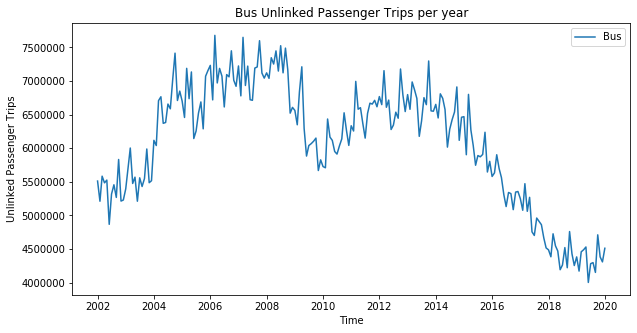

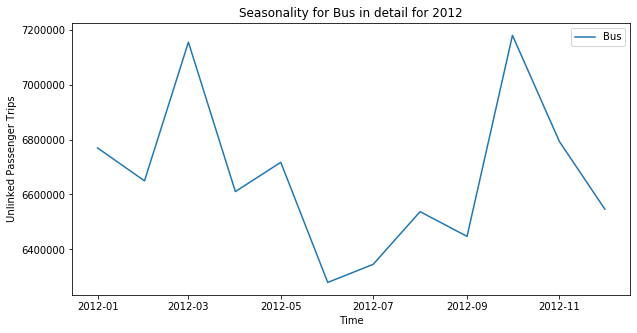

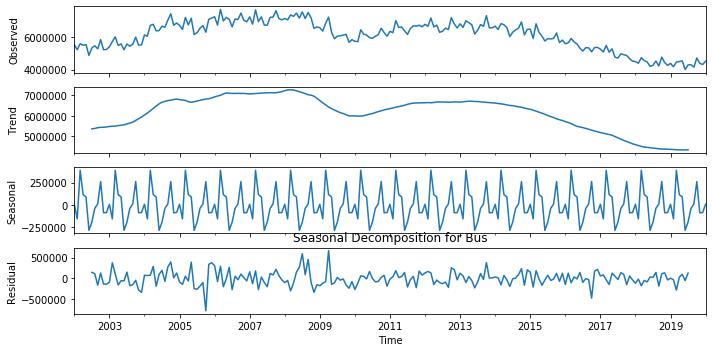

The best parameters for the SARIMAX model are: 
{'Param': (0, 1, 1), 'S_Param': (1, 1, 1, 12), 'AIC': 4528.820812248732}


                                 Statespace Model Results                                 
Dep. Variable:                                Bus   No. Observations:                  174
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2062.834
Date:                            Tue, 31 Mar 2020   AIC                           4133.668
Time:                                    18:28:02   BIC                           4145.630
Sample:                                01-01-2002   HQIC                          4138.528
                                     - 06-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

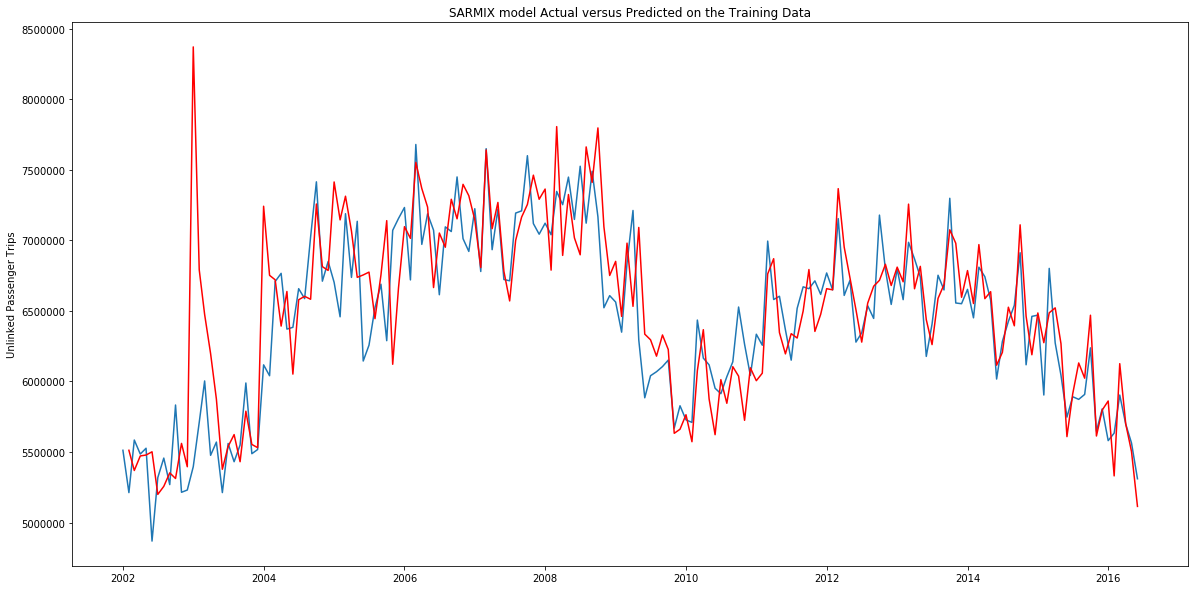

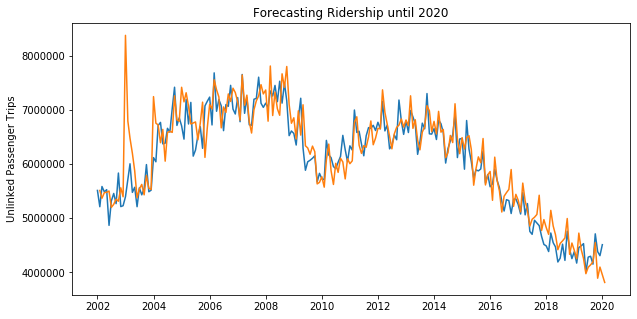

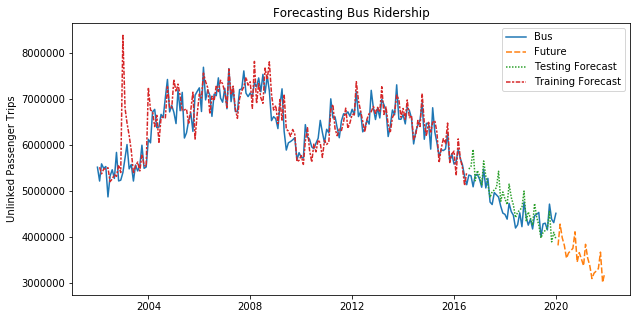

The Mean Absolute Percentage Error is: 0.04880423830387718
The Mean Error is: 107915.34829620081
The Mean Absolute Error is: 225843.44448586597
The Mean Percentage Error is: 0.022655879992352558
The Root Mean Square Error is: 281529.1819040714


In [54]:
method = (input('Please enter the method to explore (Bus or Rail): '))
method2drop = (input('Enter enter the method to exclude (Bus or Rail): '))
hurricanes_rail = ['2017-09-01', '2005-10-01']
hurricanes_bus = '2017-09-01'

def acquire ():
    data = pd.read_excel('c:/Users/denis/Desktop/Ironhack/ironhackLabs/Transportation/Users_Monthly.xlsx')
    return data

def wrangle(df):
    df = df[df['UZA Name'] == 'Miami, FL']
    df = df[df['Agency'] == 'Miami-Dade Transit']
    df = df.drop(['5 digit NTD ID', 'UZA', 'Unnamed: 226'], axis=1)
    df = df.groupby('Modes').sum()
    df = df.T
    df = df.reset_index()
    df = df.rename(columns={"index": "Time"})
    df['Time'] = pd.to_datetime(df['Time'], format='%b%y')
    df = df.set_index(['Time'], drop=True)
    df = df.drop([method2drop], axis=1)
    if method == 'Rail':
        for x in hurricanes_rail: 
            df_temp = df.reset_index()
            xloc = df_temp[df_temp["Time"]==pd.to_datetime(x)].index[0]
            avgBus = (df_temp["Rail"][xloc-1] + df_temp["Rail"][xloc+1])/2
            df.loc[x] = avgBus
    elif method == 'Bus': 
        df_temp = df.reset_index()
        xloc = df_temp[df_temp["Time"]==pd.to_datetime(hurricanes_bus)].index[0]
        avgBus = (df_temp["Bus"][xloc-1] + df_temp["Bus"][xloc+1])/2
        df.loc[hurricanes_bus] = avgBus
    filtered = df
    return filtered 

def visualize(df):
    # This graph will show how the number of unlinked passengers have changed through the years
    ax = sns.lineplot(data=df)
    ax.set_title(method + ' Unlinked Passenger Trips per year')
    ax.set_ylabel('Unlinked Passenger Trips')
    plt.show()
    # This graph will show you the seasonal trend of one year, particularly 2012 
    oneyear = df.loc['2012']
    ax2 = sns.lineplot(data=oneyear)
    ax2.set_title('Seasonality for ' + method +' in detail for 2012')
    ax2.set_ylabel('Unlinked Passenger Trips')
    plt.show()
    # This graph shows the seasonal decomposition 
    plt.rcParams['figure.figsize'] = [10, 5]
    result = seasonal_decompose(df[method])
    result.plot()
    pyplot.title('Seasonal Decomposition for ' + method)
    pyplot.savefig('seasonal_decompose.png')
    pyplot.show()
#     return graphs

def analyze(df):
    # Create Training and Test at 80% // 20%. Should standardize this for final code! 
    train = df[:174]
    test = df[174:]
    #We will perform a grid search depending on method chosen, to find the best parameters for the SARIMAX
    new = []
    p = range(0,3)
    q = range(0,3)
    d = range(1,2)
    s = range(12,13)
    # list of all parameter combos
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(p, d, q, s))
    # Finding best parameter for Bus, based on AIC
    if method == 'Bus':
        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    mod = SARIMAX(train, order=param, seasonal_order=param_seasonal, disp=0)
                    results = mod.fit(max_iter = 50, method = 'powell', disp=0)
                    new.append({'Param': param, 'S_Param': param_seasonal, 'AIC': results.aic})
                except:
                    continue
        min_bus = min(new, key=itemgetter('AIC'))
        print('The best parameters for the SARIMAX model are: ' + '\n' + str(min_bus))
    # Finding best parameter for Rail, based on MAPE
    elif method == 'Rail': 
        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    mod = SARIMAX(train, order=param,seasonal_order=param_seasonal, disp=0)
                    results = mod.fit(max_iter = 50, method = 'powell', disp=0)
                    forecast = results.predict(start=1, end=int(len(df)))
                    df['Forecast'] = forecast
                    mape = np.mean(np.abs(df["Forecast"][174:] - df["Rail"][174:])/np.abs(df["Rail"][174:]))
                    new.append({'Param': param, 'S_Param': param_seasonal, 'MAPE': mape}) 
                except:
                    continue
        min_bus = min(new, key=itemgetter('MAPE'))
        print('The best parameters for the SARIMAX model are: ' + '\n' + str(min_bus))
    print('\n')
    # We will plug the values from the grid search into the SARIMAX and plot the actual training values against what the
    # model has predicted for the training values
    model = SARIMAX(train, order=min_bus['Param'], seasonal_order=min_bus['S_Param'], enforce_stationarity=False, enforce_invertibility=False)
    fitted = model.fit()
    print(fitted.summary())
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 10)
    plt.plot(train)
    fitted_df = fitted.fittedvalues[1:]
    plt.plot(fitted_df, color='red')
    plt.title('SARMIX model Actual versus Predicted on the Training Data')
    plt.ylabel('Unlinked Passenger Trips')
    plt.show()     
    # We will use the model to forecast until the end of our data 
    forecast = fitted.predict(start=1, end=int(len(df)))
    plt.plot(df, label='Train')
    plt.plot(forecast, label='Prediction')
    plt.title('Forecasting Ridership until 2020')
    plt.ylabel('Unlinked Passenger Trips')
    plt.show()
    # We will forecast out of sample for the next two years, and plot the actual values, training data forecast, 
    # test data forecast, and the out of sample forecast
    df['Training Forecast'] = forecast[:174]
    df['Testing Forecast'] = forecast[174:]
    start = datetime.datetime.strptime("2020-02-01", "%Y-%m-%d")
    date_list = pd.date_range('2020-02-01', freq='1M', periods=23)
    future = pd.DataFrame(index=date_list, columns= df.columns)
    future.index = future.index.map(lambda t: t.replace(day=1))
    pred_uc = fitted.get_forecast(steps=66)
    future['Future'] = pred_uc.predicted_mean
    data = pd.concat([df, future])
    ax = sns.lineplot(data=data)
    ax.set_title('Forecasting ' + method + ' Ridership')
    ax.set_ylabel('Unlinked Passenger Trips')
    plt.show()
    # Exporting the data as excel to plot on Tableau 
    data.to_excel(r'Rail_F.xlsx')
    # Assessing the accuracy of model 
    mape = np.mean(np.abs(data['Testing Forecast'] - df[method][174:])/np.abs(df[method][174:]))
    print('The Mean Absolute Percentage Error is: ' + str(mape))
    me = np.mean(data['Testing Forecast'] - df[method][174:])    
    print('The Mean Error is: ' + str(me))
    mae = np.mean(np.abs(data['Testing Forecast'] - df[method][174:]))   
    print('The Mean Absolute Error is: ' + str(mae))
    mpe = np.mean((data['Testing Forecast'] - df[method][174:])/df[method][174:]) 
    print('The Mean Percentage Error is: ' + str(mpe))
    rmse = np.mean((data['Testing Forecast'] - df[method][174:])**2)**.5
    print('The Root Mean Square Error is: ' + str(rmse))
    
#     return results


if __name__ == '__main__':
    data = acquire()
    filtered = wrangle(data)
    graphs = visualize(filtered)
    results = analyze(filtered)
    
#     results = analyze(filtered)
#     barchart = visualize(results)
#     save_viz(barchart)

# Grave of less fortunate, and thus unfeatured models

# Data Cleaning

In [199]:
def mean(arr, n): 
    sum = 0
      
    for i in range(0, n): 
        sum = sum + arr[i] 
    return (sum / n)  
  
# Function to find standard  
# deviation of given array. 
def standardDeviation(arr, n): 
    sum = 0
      
    for i in range(0, n): 
        sum = (sum + (arr[i] - mean(arr, n)) *
                      (arr[i] - mean(arr, n)))  
  
    return math.sqrt(sum / (n - 1))  
  
  
# Function to find coefficient 
# of variation. 
def coefficientOfVariation(arr, n): 
    return (standardDeviation(arr, n) /
                          mean(arr, n))

arr = miami_test['Rail'].array  
n = len(arr)
  
print(coefficientOfVariation(arr, n)) 

0.13413773903314805


# Attempt 1: Stationarity via Log Transformation

In [187]:
miami = pd.read_excel('c:/Users/denis/Desktop/Ironhack/ironhackLabs/Transportation/Users_Monthly.xlsx')

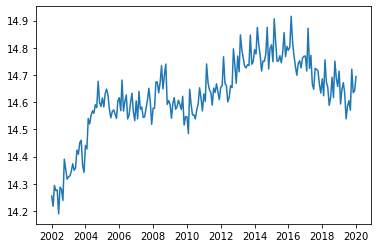

In [33]:
miami_test_logScale = np.log(miami_test)
plt.plot(miami_test_logScale)

In [34]:
movingavg = miami_test_logScale.rolling(window=12).mean()
movingstd = miami_test_logScale.rolling(window=12).std()

In [35]:
submovingavg = miami_test_logScale - movingavg
submovingavg.head()

submovingavg.dropna(inplace = True)

In [36]:
submovingavg.head()

Modes,Rail
Time,
2002-12-01,0.04
2003-01-01,0.04
2003-02-01,0.03
2003-03-01,0.05
2003-04-01,0.06


In [37]:
def test_stationarity(timeseries):

#Determing rolling stats
    movingAvg= timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

#plot rolling stats
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAvg, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='Black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

#perform dickey-fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Rail'], autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statisitc', 'p-value', '#Lags USed', '# of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

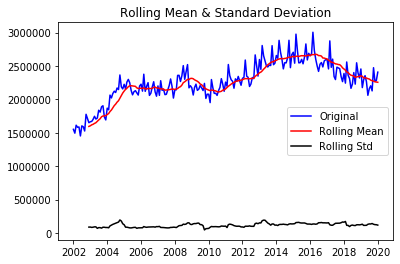

Results of Dickey-Fuller Test:
Test Statisitc            -2.63
p-value                    0.09
#Lags USed                14.00
# of Observations Used   202.00
Critical Value (1%)       -3.46
Critical Value (5%)       -2.88
Critical Value (10%)      -2.57
dtype: float64


In [38]:
test_stationarity(miami_test)

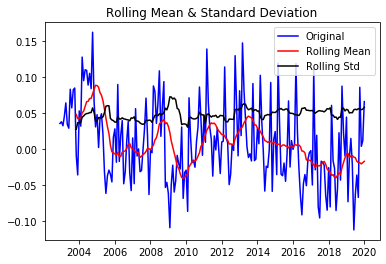

Results of Dickey-Fuller Test:
Test Statisitc            -3.42
p-value                    0.01
#Lags USed                14.00
# of Observations Used   191.00
Critical Value (1%)       -3.47
Critical Value (5%)       -2.88
Critical Value (10%)      -2.57
dtype: float64


In [39]:
test_stationarity(submovingavg)

In [40]:
weightedAvg = miami_test_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
dfweightedAvg = miami_test_logScale - weightedAvg 

# Attempt 2: Stationarity via Differencing 

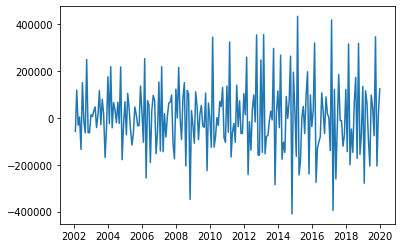

In [41]:
from matplotlib import pyplot
diff = miami_test.diff()
pyplot.plot(diff)
pyplot.show()

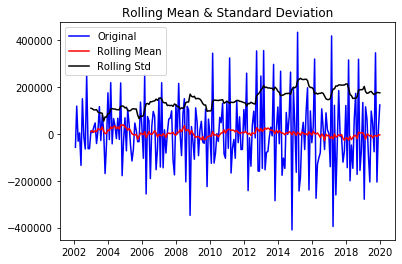

Results of Dickey-Fuller Test:
Test Statisitc            -3.43
p-value                    0.01
#Lags USed                15.00
# of Observations Used   200.00
Critical Value (1%)       -3.46
Critical Value (5%)       -2.88
Critical Value (10%)      -2.57
dtype: float64


In [42]:
diff.dropna(inplace = True)
test_stationarity(diff)

In [33]:
# diff

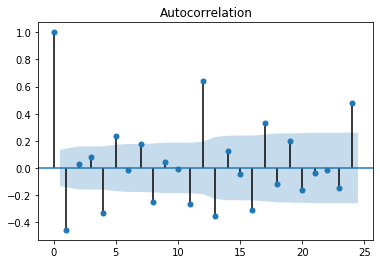

In [44]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(diff)
pyplot.show()

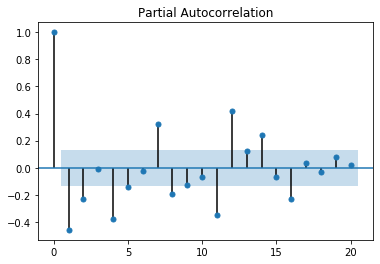

In [45]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(diff, lags=20)
pyplot.show()

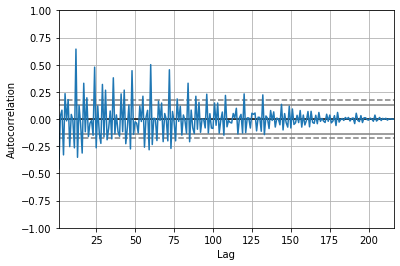

In [46]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(diff)
pyplot.show()

# Attempt 3: Stationarity via Second Differencing

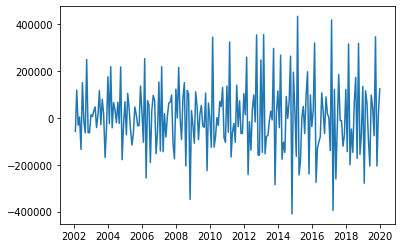

In [47]:
diff2 = miami_test.diff(periods=2)
pyplot.plot(diff)
pyplot.show()

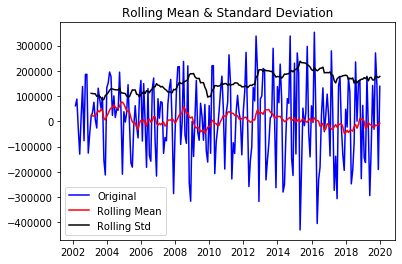

Results of Dickey-Fuller Test:
Test Statisitc            -3.39
p-value                    0.01
#Lags USed                14.00
# of Observations Used   200.00
Critical Value (1%)       -3.46
Critical Value (5%)       -2.88
Critical Value (10%)      -2.57
dtype: float64


In [48]:
diff2.dropna(inplace = True)
test_stationarity(diff2)

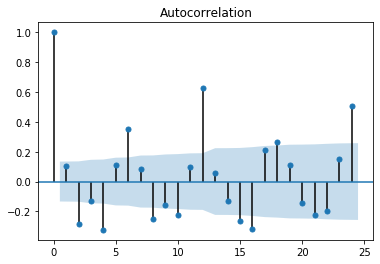

In [49]:
plot_acf(diff2)
pyplot.show()

# ARIMA models

                             ARIMA Model Results                              
Dep. Variable:                 D.Rail   No. Observations:                  216
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2840.201
Method:                       css-mle   S.D. of innovations         124080.243
Date:                Thu, 19 Mar 2020   AIC                           5692.403
Time:                        19:03:56   BIC                           5712.654
Sample:                    02-01-2002   HQIC                          5700.584
                         - 01-01-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3962.3379   2966.586      1.336      0.183   -1852.064    9776.739
ar.L1.D.Rail    -0.7905      0.128     -6.196      0.000      -1.041      -0.540
ar.L2.D.Rail    -0.0717      0.111     -0.64

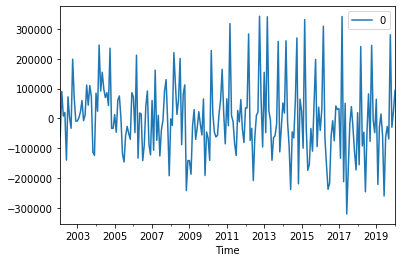

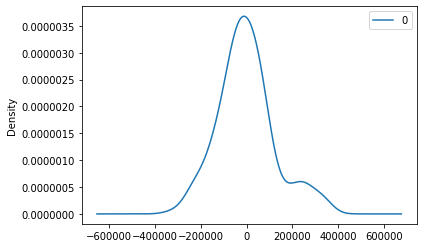

               0
count     216.00
mean    -1007.87
std    124414.15
min   -320453.45
25%    -71220.26
50%     -9136.87
75%     62211.31
max    342646.28


In [50]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(miami_test, order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

                             ARIMA Model Results                              
Dep. Variable:                 D.Rail   No. Observations:                  216
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2842.157
Method:                       css-mle   S.D. of innovations         125225.621
Date:                Thu, 19 Mar 2020   AIC                           5692.314
Time:                        19:03:57   BIC                           5705.815
Sample:                    02-01-2002   HQIC                          5697.768
                         - 01-01-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3962.3379   2823.786      1.403      0.162   -1572.182    9496.857
ar.L1.D.Rail     0.0598      0.101      0.592      0.554      -0.138       0.258
ma.L1.D.Rail    -0.6923      0.072     -9.56

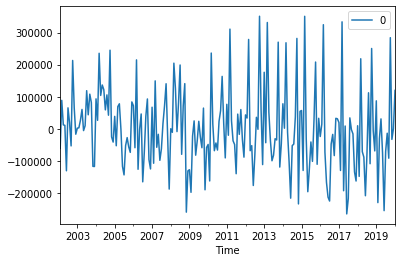

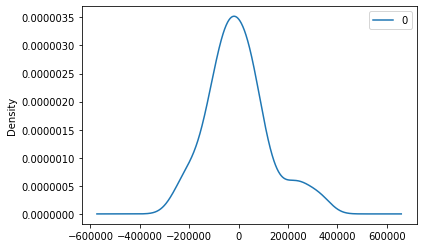

               0
count     216.00
mean    -1065.78
std    125554.40
min   -265522.24
25%    -78185.53
50%    -12535.68
75%     59979.72
max    350773.95


In [51]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(miami_test, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

                             ARIMA Model Results                              
Dep. Variable:                D2.Rail   No. Observations:                  215
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -2837.523
Method:                       css-mle   S.D. of innovations         128393.446
Date:                Thu, 19 Mar 2020   AIC                           5685.046
Time:                        19:03:58   BIC                           5701.899
Sample:                    03-01-2002   HQIC                          5691.855
                         - 01-01-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -83.8677     78.931     -1.063      0.289    -238.570      70.835
ar.L1.D2.Rail    -0.5616      0.066     -8.450      0.000      -0.692      -0.431
ar.L2.D2.Rail    -0.2276      0.066     

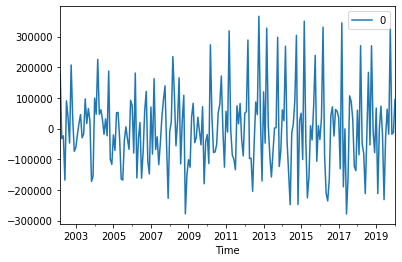

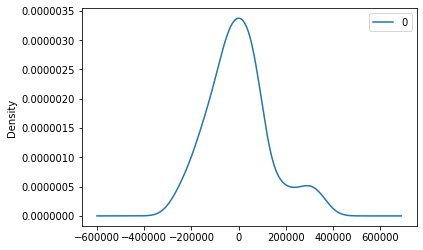

               0
count     215.00
mean     -141.12
std    130076.17
min   -278165.21
25%    -82050.16
50%    -11133.46
75%     61838.93
max    366308.76


In [52]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(miami_test, order=(2,2,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

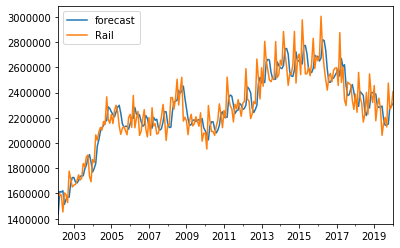

In [53]:
model_fit.plot_predict(dynamic=False)
plt.show()

# Training the model

In [175]:
from statsmodels.tsa.stattools import acf

# Create Training and Test at 80% // 20%. Should standardize this for final code! 
train = miami_test[:174]
test = miami_test[174:]

In [61]:
model = ARIMA(train, order=(1,1, 1))  
fitted = model.fit()  

In [24]:
# train

In [63]:
fc, se, conf = fitted.forecast(43, alpha=0.05)  # 95% conf

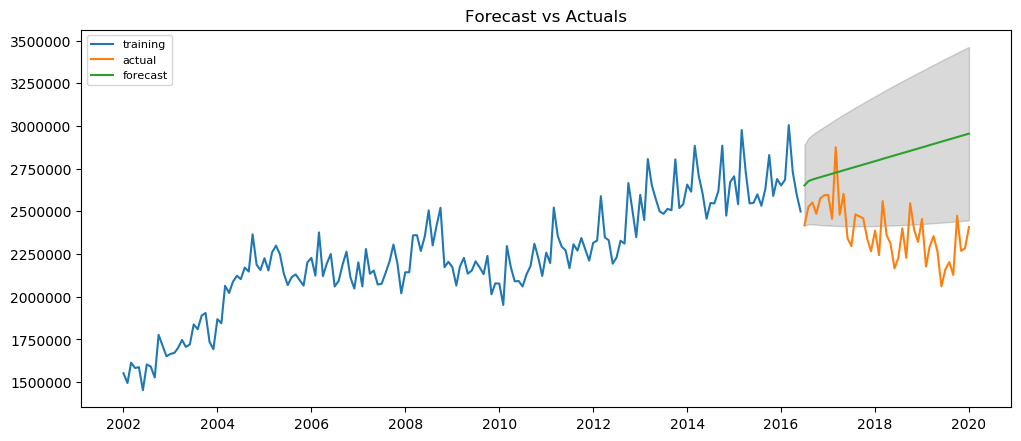

In [64]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [65]:
# predictions = fitted.forecast(64)[0]

In [66]:
# predictions

In [67]:
print(fitted.aic)

4547.439084961434


In [68]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
#     corr = np.corrcoef(forecast, actual)[0,1]   # corr
#     mins = np.amin(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     maxs = np.amax(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
# ?                    # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

forecast_accuracy(fc, test.values)

{'mape': 0.18662528072719006,
 'me': 429796.45039658877,
 'mae': 433229.300439103,
 'mpe': 0.18543144483323495,
 'rmse': 465725.10646503186}

# Trying different models

In [69]:
model = ARIMA(train, order=(2,2, 0))  
fitted = model.fit()  

In [70]:
fc, se, conf = fitted.forecast(43, alpha=0.05)  # 95% conf

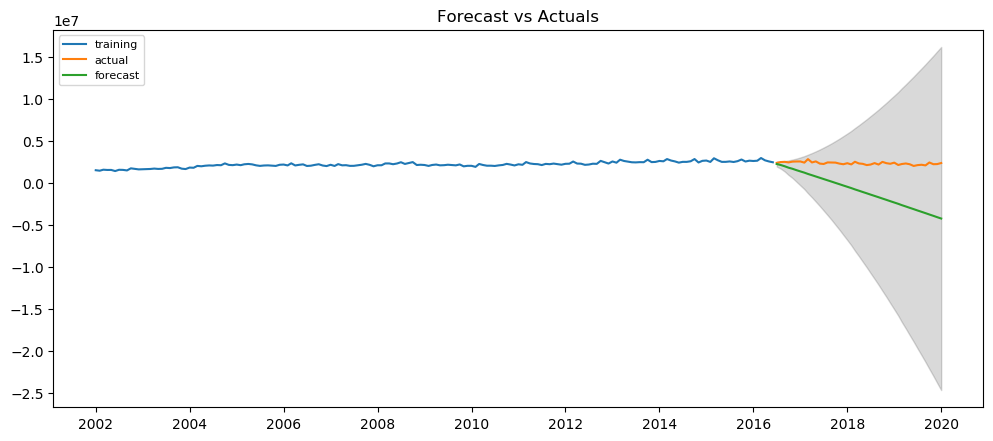

In [71]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [72]:
print(fitted.aic)

4607.354915376044


In [73]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

forecast_accuracy(fc, test.values)

{'mape': 1.383238899841477,
 'me': -3291862.70524056,
 'mae': 3293259.1587543003,
 'mpe': -1.3825888544603857,
 'rmse': 3817478.505182482}